# Spiral Sequence Development with Pypulseq (Marten Veldmann, DZNE Bonn)

In [1]:
import numpy as np
import os

# Pypulseq
from pypulseq.make_arbitrary_grad import make_arbitrary_grad
from pypulseq.Sequence.sequence import Sequence
from pypulseq.make_adc import make_adc
from pypulseq.make_sinc_pulse import make_sinc_pulse
from pypulseq.make_trap_pulse import make_trapezoid
from pypulseq.make_delay import make_delay
from pypulseq.opts import Opts

# spiral trajectory
import spiraltraj

# ISMRMRD
import ismrmrd

# rotation of spiral gradients
def rot_grad(gx, gy, phi):
    gx_rot = np.cos(phi)*gx-np.sin(phi)*gy
    gy_rot = np.sin(phi)*gx+np.cos(phi)*gy    
    
    return gx_rot, gy_rot

In [2]:
# set system limits
max_slew = 200 # maximum gradient slewrate
max_grad = 70  # maximum gradient amplitude

system = Opts(max_grad=max_grad, grad_unit='mT/m', max_slew=max_slew, slew_unit='T/m/s', rf_ringdown_time=30e-6,
              rf_dead_time=100e-6)

In [3]:
#############################
# Define and write Sequence
#############################

# Filename fo sequence and protocol
filename = "spiral_example"

# make rf pulse, slice selection gradient & rewinder
flip_angle      = 15 # [°]
rf_duration     = 3  # [ms] 
slice_thickness = 2  # [mm]

rf, gz, gz_rew = make_sinc_pulse(flip_angle=flip_angle*np.pi/180, system=system, duration=rf_duration*1e-3, 
                                 slice_thickness=slice_thickness*1e-3, apodization=0.5, time_bw_product=5, 
                                 use='excitation', return_gz=True)

# calculate spiral
nitlv      = 9   # spiral interleaves
fov        = 192 # field of view [mm]
res        = 1   # in-plane resolution [mm]
spiraltype = 1   # spiral out
min_rise   = 6   # minimum gradient rise time 
max_amp    = 42  # maximum gradient amplitude


# Spirals
spiral_calc = spiraltraj.calc_traj(nitlv=nitlv, fov=fov, res=res, spiraltype=spiraltype, 
                                   min_rise=min_rise, max_amp=max_amp)
spiral_x = np.asarray(spiral_calc)[:,0]
spiral_y = np.asarray(spiral_calc)[:,1]

# ADC
dwelltime        = 2e-6                                  # ADC dwelltime [s]
readout_duration = len(spiral_x)*system.grad_raster_time # length of readout [s]
num_samples      = int(readout_duration/dwelltime)       # ADC samples
adc = make_adc(system=system, num_samples=num_samples, dwell=dwelltime)

# Make sequence for one 2D slice
seq = Sequence()
seq.set_definition("Name", filename)
if os.path.exists(filename+'.h5'):
    os.remove(filename+'.h5')
prot = ismrmrd.Dataset(filename+'.h5')

for k in range(nitlv):
    # rotate interleaves
    rot_angle = np.linspace(0, 2*np.pi, nitlv, endpoint=False)
    spiral_x_, spiral_y_ = rot_grad(spiral_x, spiral_y, rot_angle[k])
    
    # make spiral gradients with Pypulseq
    spiral_x_grad = make_arbitrary_grad(channel='x', waveform=spiral_x_, system=system)
    spiral_y_grad = make_arbitrary_grad(channel='y', waveform=spiral_y_, system=system)

    # add blocks to sequence
    seq.add_block(rf,gz)
    seq.add_block(gz_rew)
    seq.add_block(spiral_x_grad, spiral_y_grad, adc)
    
    # add acquisitions to protocol
    acq = ismrmrd.Acquisition()
    if (k == nitlv - 1):
        acq.setFlag(ismrmrd.ACQ_LAST_IN_SLICE)
    acq.idx.kspace_encode_step_1 = k
    acq.idx.slice = 0
    acq.resize(trajectory_dimensions = 2, number_of_samples=len(spiral_x_), active_channels=32)
    acq.traj[:] = np.stack([spiral_x_,spiral_y_]).T # save gradients instead of trajectory as GIRF trajectory prediction is done in recon
    prot.append_acquisition(acq)
    
# write sequence file
seq.write(filename+'.seq')

/home/veldmannm/Software/PythonPackages/pypulseq/pypulseq/Sequence/sequence.py:723: ResourceWarning: unclosed file <_io.TextIOWrapper name='spiral_example.seq' mode='w' encoding='UTF-8'>
  write(self, name)


In [4]:
#############################
# Create header for protocol
#############################

hdr = ismrmrd.xsd.ismrmrdHeader()
    
# experimental conditions
exp = ismrmrd.xsd.experimentalConditionsType()
exp.H1resonanceFrequency_Hz = 298060000 # 7T
hdr.experimentalConditions = exp

# user parameters
dtime = ismrmrd.xsd.userParameterDoubleType()
dtime.name = 'dwellTime_us'
dtime.value_ = dwelltime * 1e6
hdr.userParameters = ismrmrd.xsd.userParametersType()
hdr.userParameters.userParameterDouble.append(dtime)

# encoding
encoding = ismrmrd.xsd.encodingType()
encoding.trajectory = ismrmrd.xsd.trajectoryType('spiral')

# set fov and matrix size
efov = ismrmrd.xsd.fieldOfViewMm()
efov.x = fov
efov.y = fov
efov.z = slice_thickness
rfov = ismrmrd.xsd.fieldOfViewMm()
rfov.x = fov
rfov.y = fov
rfov.z = slice_thickness
ematrix = ismrmrd.xsd.matrixSizeType()
ematrix.x = int(fov/res+0.5)
ematrix.y = int(fov/res+0.5)
ematrix.z = 1 # 2D
rmatrix = ismrmrd.xsd.matrixSizeType()
rmatrix.x = int(fov/res+0.5)
rmatrix.y = int(fov/res+0.5)
rmatrix.z = 1

# set encoded and recon spaces
espace = ismrmrd.xsd.encodingSpaceType()
espace.matrixSize = ematrix
espace.fieldOfView_mm = efov
rspace = ismrmrd.xsd.encodingSpaceType()
rspace.matrixSize = rmatrix
rspace.fieldOfView_mm = rfov
encoding.encodedSpace = espace
encoding.reconSpace = rspace
    
# encoding limits
limits = ismrmrd.xsd.encodingLimitsType()
limits.slice = ismrmrd.xsd.limitType()
limits.slice.minimum = 0
limits.slice.maximum = 0
limits.slice.center = 0

limits.kspace_encoding_step_1 = ismrmrd.xsd.limitType()
limits.kspace_encoding_step_1.minimum = 0
limits.kspace_encoding_step_1.maximum = nitlv - 1
limits.kspace_encoding_step_1.center = int(nitlv - 1 + 0.5)
encoding.encodingLimits = limits

# append encoding
hdr.encoding.append(encoding)

# append header to protocol file
prot.write_xml_header(hdr.toXML('utf-8'))
prot.close()

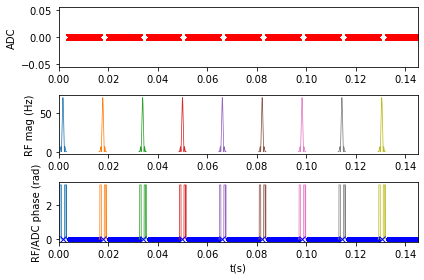

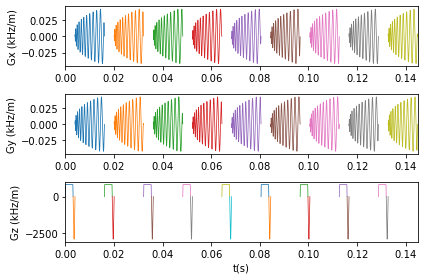

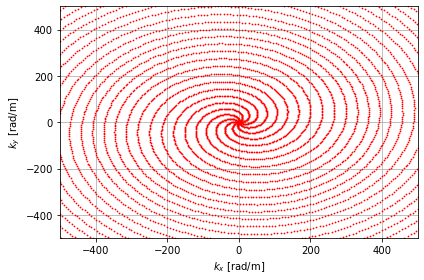

In [5]:
# plot sequence
import matplotlib.pyplot as plt
%matplotlib inline

# plot sequence diagram with pypulseq's plot command
seq.plot(time_disp = 's')

# calculate kspace
ktraj_adc, ktraj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()

# plot trajectory and zoom in
plt.plot(ktraj_adc[0, :]*1e-3*system.gamma*2*np.pi, ktraj_adc[1, :]*1e-3*system.gamma*2*np.pi, 'r.', markersize=1.5)
plt.xlabel('$k_x$ [rad/m]')
plt.ylabel('$k_y$ [rad/m]')
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.grid()
plt.tight_layout()
